In [1]:
# Import necessary libaries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from requests import get

In [2]:
# Make a request
url = 'https://covid19.ncdc.gov.ng'
response = get(url, headers = {"Accept-Language": "en-US, en;q=0.5"})

In [3]:
print(response.text[:500])

<!DOCTYPE html>
<html lang="en">
<meta http-equiv="content-type" content="text/html;charset=UTF-8" />
<head>
<title>NCDC Coronavirus COVID-19 Microsite</title>
<!--[if lt IE 11]>
    	<script src="https://oss.maxcdn.com/libs/html5shiv/3.7.0/html5shiv.js"></script>
    	<script src="https://oss.maxcdn.com/libs/respond.js/1.4.2/respond.min.js"></script>
    	<![endif]-->
<meta charset="utf-8">
<meta name="viewport" content="width=device-width, initial-scale=1.0, user-scalable=0, minimal-ui">
<meta


In [4]:
# Create a beautifulsoup object
html_soup = BeautifulSoup(response.text, 'html.parser')
type(html_soup)

bs4.BeautifulSoup

In [5]:
# Locate table
covid_table = html_soup.find('div', class_ = 'table-responsive')

In [17]:
# Scrape table headers and pass into a list
table_heading = covid_table.thead.find_all('th')
headings = []
for th in table_heading:
    headings.append(th.text)
print(headings)

['States Affected', 'No. of Cases (Lab Confirmed)', 'No. of Cases (on admission)', 'No. Discharged', 'No. of Deaths']


In [18]:
# Scrape table rows and pass into a list
table_rows = []
for i in covid_table.tbody.find_all('tr'):
    table_rows.append(i.text.replace('\n', ' ').strip())
table_rows

['Lagos  6,611  5,532  997  82',
 'FCT  1,097  792  280  25',
 'Kano  1,048  442  556  50',
 'Ogun  523  296  214  13',
 'Edo  490  343  122  25',
 'Rivers  454  244  188  22',
 'Oyo  434  309  118  7',
 'Katsina  411  171  219  21',
 'Bauchi  392  152  230  10',
 'Kaduna  392  141  241  10',
 'Borno  381  150  205  26',
 'Jigawa  314  138  171  5',
 'Gombe  293  146  135  12',
 'Delta  225  151  63  11',
 'Ebonyi  152   82  70  0',
 'Kwara  143  72  70  1',
 'Plateau  130  28  99  3',
 'Sokoto  129  12  103  14',
 'Nasarawa  128  92  31  5',
 'Imo  114  94  19  1',
 'Abia  97   81  16  0',
 'Zamfara  76  0  71  5',
 'Ondo  54  14  31  9',
 'Anambra  53  39  13  1',
 'Yobe  52  20  25  7',
 'Osun  50  6  40  4',
 'Kebbi  47   13  29  5',
 'Niger  46  19  26  1',
 'Akwa Ibom  45  28  15  2',
 'Adamawa  42  4  34  4',
 'Enugu  35  20  14  1',
 'Bayelsa  32  9  20  3',
 'Ekiti  30  10  18  2',
 'Taraba  18  8  10  0',
 'Benue  13  12  1  0',
 'Kogi  3  3  0  0']

In [19]:
# Format table rows for dataframe
table_rows = [i.split() for i in table_rows]
table_rows

[['Lagos', '6,611', '5,532', '997', '82'],
 ['FCT', '1,097', '792', '280', '25'],
 ['Kano', '1,048', '442', '556', '50'],
 ['Ogun', '523', '296', '214', '13'],
 ['Edo', '490', '343', '122', '25'],
 ['Rivers', '454', '244', '188', '22'],
 ['Oyo', '434', '309', '118', '7'],
 ['Katsina', '411', '171', '219', '21'],
 ['Bauchi', '392', '152', '230', '10'],
 ['Kaduna', '392', '141', '241', '10'],
 ['Borno', '381', '150', '205', '26'],
 ['Jigawa', '314', '138', '171', '5'],
 ['Gombe', '293', '146', '135', '12'],
 ['Delta', '225', '151', '63', '11'],
 ['Ebonyi', '152', '82', '70', '0'],
 ['Kwara', '143', '72', '70', '1'],
 ['Plateau', '130', '28', '99', '3'],
 ['Sokoto', '129', '12', '103', '14'],
 ['Nasarawa', '128', '92', '31', '5'],
 ['Imo', '114', '94', '19', '1'],
 ['Abia', '97', '81', '16', '0'],
 ['Zamfara', '76', '0', '71', '5'],
 ['Ondo', '54', '14', '31', '9'],
 ['Anambra', '53', '39', '13', '1'],
 ['Yobe', '52', '20', '25', '7'],
 ['Osun', '50', '6', '40', '4'],
 ['Kebbi', '47', '13

In [27]:
# Locate index position of Akwa Ibom
def get_index(strings, substr):
    for idx, string in enumerate(strings):
        if substr in string:
            break
    return idx

In [31]:
idx = get_index(table_rows, 'Akwa')

In [32]:
# Join 'Akwa' and 'Ibom'
del table_rows[idx][1]
table_rows[idx][0] = 'Akwa Ibom'
table_rows

[['Lagos', '6,611', '5,532', '997', '82'],
 ['FCT', '1,097', '792', '280', '25'],
 ['Kano', '1,048', '442', '556', '50'],
 ['Ogun', '523', '296', '214', '13'],
 ['Edo', '490', '343', '122', '25'],
 ['Rivers', '454', '244', '188', '22'],
 ['Oyo', '434', '309', '118', '7'],
 ['Katsina', '411', '171', '219', '21'],
 ['Bauchi', '392', '152', '230', '10'],
 ['Kaduna', '392', '141', '241', '10'],
 ['Borno', '381', '150', '205', '26'],
 ['Jigawa', '314', '138', '171', '5'],
 ['Gombe', '293', '146', '135', '12'],
 ['Delta', '225', '151', '63', '11'],
 ['Ebonyi', '152', '82', '70', '0'],
 ['Kwara', '143', '72', '70', '1'],
 ['Plateau', '130', '28', '99', '3'],
 ['Sokoto', '129', '12', '103', '14'],
 ['Nasarawa', '128', '92', '31', '5'],
 ['Imo', '114', '94', '19', '1'],
 ['Abia', '97', '81', '16', '0'],
 ['Zamfara', '76', '0', '71', '5'],
 ['Ondo', '54', '14', '31', '9'],
 ['Anambra', '53', '39', '13', '1'],
 ['Yobe', '52', '20', '25', '7'],
 ['Osun', '50', '6', '40', '4'],
 ['Kebbi', '47', '13

In [33]:
# Pass table rows into data frame
data = pd.DataFrame(table_rows)
data.head()

,0,1,2,3,4
0,Lagos,"6,611","5,532",997,82
1,FCT,"1,097",792,280,25
2,Kano,"1,048",442,556,50
3,Ogun,523,296,214,13
4,Edo,490,343,122,25


In [34]:
# Set table headers from headings list
data.columns = headings
data.head()

,States Affected,No. of Cases (Lab Confirmed),No. of Cases (on admission),No. Discharged,No. of Deaths
0,Lagos,"6,611","5,532",997,82
1,FCT,"1,097",792,280,25
2,Kano,"1,048",442,556,50
3,Ogun,523,296,214,13
4,Edo,490,343,122,25


In [35]:
# Remove all commas from columns
data.replace(',','', regex=True, inplace=True)

In [36]:
col = data.select_dtypes(object).columns[1:]
data[col] = data[col].apply(pd.to_numeric, errors='coerce')

In [37]:
data.dtypes

States Affected                 object
No. of Cases (Lab Confirmed)     int64
No. of Cases (on admission)      int64
No. Discharged                   int64
No. of Deaths                    int64
dtype: object

In [38]:
# Rename FCT to Abuja FCT
data.loc[data['States Affected'] == 'FCT', 'States Affected'] = 'Federal Capital Territory'

In [39]:
data.columns = ['States', 'Cases', 'Infected', 'Recoveries', 'Deaths']

In [40]:
data.head(3)

,States,Cases,Infected,Recoveries,Deaths
0,Lagos,6611,5532,997,82
1,Federal Capital Territory,1097,792,280,25
2,Kano,1048,442,556,50


In [41]:
# Export data frame to csv
data.to_csv('covid_nigeria.csv')

In [42]:
# Import libararies for map plotting
import geopandas as gpd
import geoplot as gpt
import matplotlib.pyplot as plt

In [43]:
# Load SHP files
shp = r'shapefile/Nigeria_Poly.shp'
shapefile = gpd.read_file(shp)

In [44]:
type(shapefile), shapefile.shape

(geopandas.geodataframe.GeoDataFrame, (37, 16))

In [45]:
shapefile.columns

Index(['id', 'country', 'name', 'enname', 'locname', 'offname', 'boundary',
       'adminlevel', 'wikidata', 'wikimedia', 'timestamp', 'note', 'path',
       'rpath', 'iso3166_2', 'geometry'],
      dtype='object')

In [46]:
# Drop unecassary columns
shapefile = shapefile.drop(['id', 'country', 'name', 'enname', 'offname', 'boundary',
       'adminlevel', 'wikidata', 'wikimedia', 'timestamp', 'note', 'path',
       'rpath', 'iso3166_2'], axis=1)

In [47]:
shapefile.columns = ['States', 'geometry']

In [48]:
shapefile.head(2)

,States,geometry
0,Abia,"POLYGON ((7.14043 4.90063, 7.14377 4.91320, 7...."
1,Adamawa,"POLYGON ((11.34152 8.01867, 11.34154 8.02210, ..."


In [49]:
# Merge GeoDataFrame with covid statistics data
data = shapefile.merge(data, left_on='States', right_on='States')

In [50]:
type(data), data.shape

(geopandas.geodataframe.GeoDataFrame, (36, 6))

In [51]:
data.head(2)

,States,geometry,Cases,Infected,Recoveries,Deaths
0,Abia,"POLYGON ((7.14043 4.90063, 7.14377 4.91320, 7....",97,81,16,0
1,Adamawa,"POLYGON ((11.34152 8.01867, 11.34154 8.02210, ...",42,4,34,4


In [52]:
data.head(3)

,States,geometry,Cases,Infected,Recoveries,Deaths
0,Abia,"POLYGON ((7.14043 4.90063, 7.14377 4.91320, 7....",97,81,16,0
1,Adamawa,"POLYGON ((11.34152 8.01867, 11.34154 8.02210, ...",42,4,34,4
2,Akwa Ibom,"MULTIPOLYGON (((8.34338 4.60775, 8.34241 4.606...",45,28,15,2


In [91]:
# Define plot function
def visual(data, hue, cmap):
    fig, ax = plt.subplots(1, figsize=(38, 13))
    ax.set_title('Coronavirus {} by States'.format(hue), fontdict={'fontsize': '20', 'fontweight' : '3'})
    gpt.choropleth(data, hue=hue, cmap=cmap,
                   legend=True,edgecolor='lightgray', linewidth=0.1,
                   ax=ax,legend_kwargs={'aspect':30, 'label':'Counts', 'fraction':0.036, 'pad':0, 'orientation':'horizontal'});

    data['coords'] = data['geometry'].apply(lambda x: x.representative_point().coords[:])
    data['coords'] = [coords[0] for coords in data['coords']]

    for idx, row in data.iterrows():
        ax.annotate(s=row['States'], xy=row['coords'], color='black', fontsize=13, horizontalalignment='center')
        plt.savefig('{}.png'.format(hue.lower()))

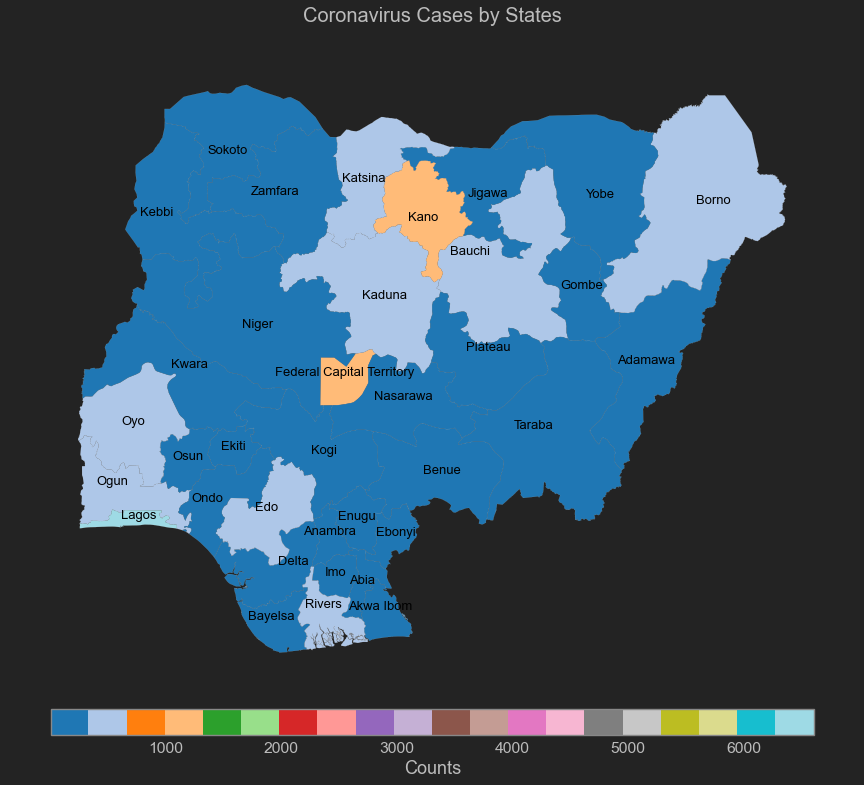

In [95]:
# Plot geomap for cases
visual(data, 'Cases', 'tab20')

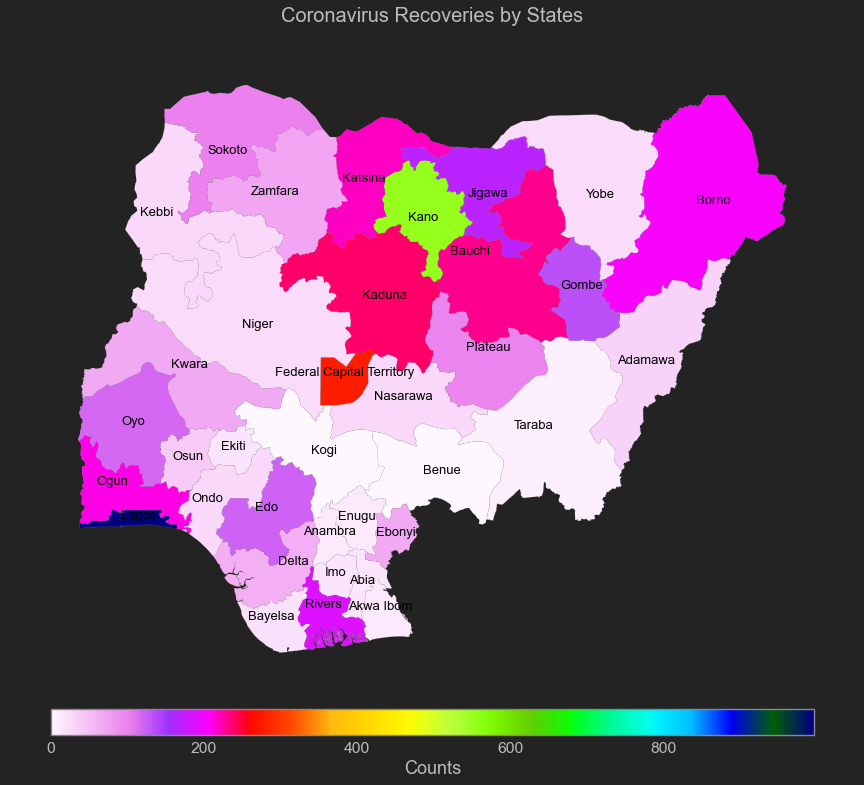

In [96]:
# Plot geomap for recoveries
visual(data, 'Recoveries', 'gist_ncar_r')

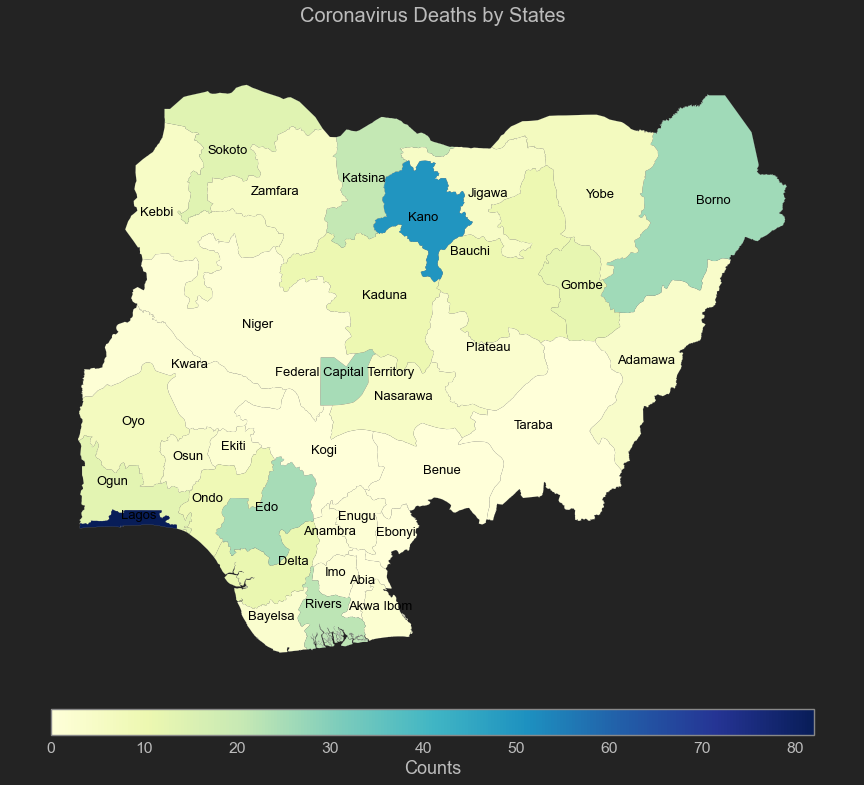

In [97]:
# Plot geomap for deaths
visual(data, 'Deaths', 'YlGnBu')

<h1 align='center'>Time Series Data</h1>

<p>Download data from Johns Hopkins University (JHU) Center for Systems Science and Engineering's (CSSE) GitHub repository</p>

In [57]:
cases = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

In [58]:
recovs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [59]:
deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

In [60]:
# Read data into data frame
df_cases = pd.read_csv(cases)
df_recovs = pd.read_csv(recovs)
df_deaths = pd.read_csv(deaths)

In [61]:
# Extract confirmed cases data for Nigeria
df_cases.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
df_cases.set_index('Country/Region', inplace=True)
df_cases = df_cases.loc['Nigeria']
df_cases = pd.DataFrame(df_cases)
df_cases.columns = ['Cases']
df_cases = df_cases.loc['2/28/20':]

In [62]:
# Extract recoveries data for Nigeria
df_recovs.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
df_recovs.set_index('Country/Region', inplace=True)
df_recovs = df_recovs.loc['Nigeria']
df_recovs = pd.DataFrame(df_recovs)
df_recovs.columns = ['Recoveries']
df_recovs = df_recovs.loc['2/28/20':]

In [63]:
# Extract death data for Nigeria
df_deaths.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
df_deaths.set_index('Country/Region', inplace=True)
df_deaths = df_deaths.loc['Nigeria']
df_deaths = pd.DataFrame(df_deaths)
df_deaths.columns = ['Deaths']
df_deaths = df_deaths.loc['2/28/20':]

In [64]:
# Merge cases, recoveriies and death data into one data frame
time_series = pd.concat([df_cases, df_recovs, df_deaths], axis=1, ignore_index=False)

In [65]:
# Rename columns
time_series.reset_index(inplace=True)
time_series.columns = ['Time', 'Cases', 'Recoveries', 'Deaths']

In [66]:
# Set time column type to datetime

#date = pd.date_range("1 22 2020", periods=time_series.shape[0], freq="D", name="date")
time_series['Time'] = pd.to_datetime(time_series['Time'], errors='coerce')

In [67]:
# Make time column index of the data frame
time_series.set_index('Time', inplace=True)

In [68]:
time_series.head()

,Cases,Recoveries,Deaths
Time,,,
2020-02-28,1,0,0
2020-02-29,1,0,0
2020-03-01,1,0,0
2020-03-02,1,0,0
2020-03-03,1,0,0


In [69]:
# Export time series data to csv
time_series.to_csv('time_series.csv')

In [70]:
# Import libraries for plotting
import seaborn as sns
from jupyterthemes import jtplot
import matplotlib.dates as mdates

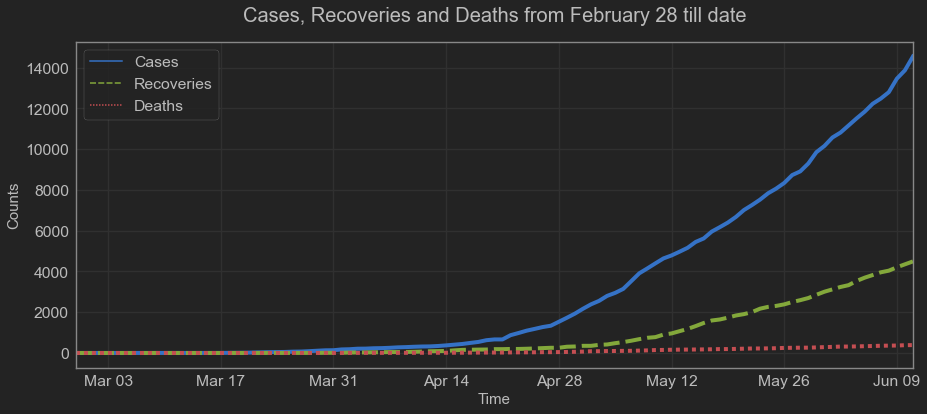

In [73]:
fig, ax = plt.subplots(figsize=(15, 6))
jtplot.style(theme='monokai', context='notebook', fscale=1.5, spines=True)
sns.lineplot(data=time_series, ax=ax, linewidth=4)
ax.set_title('Cases, Recoveries and Deaths from February 28 till date', fontdict={'fontsize': '20', 'fontweight' : '3'}, pad=20)
ax.set_ylabel('Counts', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xlabel('Time', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xlim(time_series.index[0], time_series.index[-1])

# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
# Format x-tick labels to show at 2 weeks interval
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
# Save figure
plt.savefig('line-plot.png')

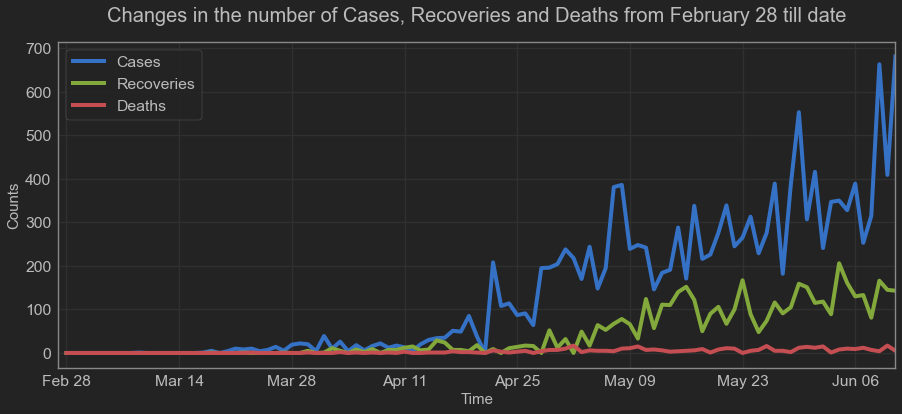

In [72]:
fig, ax = plt.subplots(figsize=(15, 6))
jtplot.style(theme='monokai', context='notebook', fscale=1.5, spines=True)
time_series.diff().plot(ax=ax, linewidth=4)
ax.set_title('Changes in the number of Cases, Recoveries and Deaths from February 28 till date', fontdict={'fontsize': '20', 'fontweight' : '3'}, pad=20)
ax.set_ylabel('Counts', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xlabel('Time', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xlim(time_series.index[0], time_series.index[-1])

# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
# Format x-tick labels to show at 2 weeks interval
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
# Save figure
plt.savefig('time-lag.png')